# **Installation**

In [1]:
# !pip install matplotlib tiktoken datasets tensorflow

# **Imports**

In [2]:
from importlib.metadata import version

pkgs = ["matplotlib",
        "numpy",
        "tiktoken",
        "torch",
        "tensorflow" # For OpenAI's pretrained weights
       ]
for p in pkgs:
    print(f"{p} version: {version(p)}")

matplotlib version: 3.9.3
numpy version: 2.0.2
tiktoken version: 0.8.0
torch version: 2.5.1
tensorflow version: 2.18.0


In [3]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import tiktoken
from datasets import load_dataset
import time
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import wandb

# **Model Initialization**

In [4]:
#@title **Model Architecture**

class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert d_out % num_heads == 0, "d_out must be divisible by n_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads  # Reduce the projection dim to match desired output dim

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1))

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x)  # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2)

        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.reshape(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec)  # optional projection

        return context_vec


class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift


class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))


class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)


class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"],
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        # Shortcut connection for attention block
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)   # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        # Shortcut connection for feed-forward block
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        return x


class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits


def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx is (B, T) array of indices in the current context
    for _ in range(max_new_tokens):

        # Crop current context if it exceeds the supported context size
        # E.g., if LLM supports only 5 tokens, and the context size is 10
        # then only the last 5 tokens are used as context
        idx_cond = idx[:, -context_size:]

        # Get the predictions
        with torch.no_grad():
            logits = model(idx_cond)

        # Focus only on the last time step
        # (batch, n_token, vocab_size) becomes (batch, vocab_size)
        logits = logits[:, -1, :]

        # Get the idx of the vocab entry with the highest logits value
        idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch, 1)

        # Append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)

    return idx


def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):

    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        if top_k is not None:
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float('-inf')).to(logits.device), logits)

        if temperature > 0.0:
            logits = logits / temperature

            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)

            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)

        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        if idx_next == eos_id:  # Stop generating early if end-of-sequence token is encountered and eos_id is specified
            break

        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx


def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)  # add batch dimension
    return encoded_tensor


def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0)  # remove batch dimension
    return tokenizer.decode(flat.tolist())

In [5]:
# GPT_CONFIG_124M = {
#     "vocab_size": 50257,   # Vocabulary size
#     "context_length": 256, # Shortened context length (orig: 1024)
#     "emb_dim": 768,        # Embedding dimension
#     "n_heads": 12,         # Number of attention heads
#     "n_layers": 12,        # Number of layers
#     "drop_rate": 0.1,      # Dropout rate
#     "qkv_bias": False      # Query-key-value bias
# }

# torch.manual_seed(100)
# model = GPTModel(GPT_CONFIG_124M)
# model.eval();  # Disable dropout during inference

In [6]:
GPT_CONFIG_70M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 256, # Shortened context length (orig: 1024)
    "emb_dim": 512,        # Embedding dimension
    "n_heads": 8,         # Number of attention heads
    "n_layers": 6,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}

torch.manual_seed(100)
model = GPTModel(GPT_CONFIG_70M)
model.eval();  # Disable dropout during inference

In [7]:
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_70M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you devotion assembledagnetic arbitrarily complexes Cort Percentros UPonse


In [8]:
inputs = torch.tensor([[16833, 3626, 6100],   # ["every effort moves",
                       [40,    1107, 588]])   #  "I really like"]

targets = torch.tensor([[3626, 6100, 345  ],  # [" effort moves you",
                        [1107,  588, 11311]]) #  " really like chocolate"]

with torch.no_grad():
    logits = model(inputs)

probas = torch.softmax(logits, dim=-1) # Probability of each token in vocabulary

token_ids = torch.argmax(probas, dim=-1, keepdim=True)

text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]

text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]

log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))

avg_log_probas = torch.mean(log_probas)

neg_avg_log_probas = avg_log_probas * -1

logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()

loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)

perplexity = torch.exp(loss)

# **Dataset**

**Dataset Loading**

In [9]:
dataset = load_dataset("Haxirus/rasbt_pretraining_data", split="train")

text_data = dataset['Text']

print(text_data[:1])

print(text_data[0][:100])  # Prints the first 100 characters of the first entry

["Drug A is Abaloparatide. Drug B is Acebutolol. The severity of the interaction is minor. The risk or severity of adverse effects can be increased when Acebutolol is combined with Abaloparatide. Co-administration of agents that are both associated with a risk for developing hypotension, including cases of severe hypotension, may create an additive hypotensive effect to prolong and intensify hypotensive effects. Abaloparatide is indicated for the treatment of postmenopausal women with osteoporosis at high risk for fracture (defined as a history of osteoporotic fracture or multiple risk factors for fracture) or patients who have failed or are intolerant to other available osteoporosis therapy. In postmenopausal women with osteoporosis, abaloparatide reduces the risk of vertebral and nonvertebral fractures. Abaloparatide is also indicated to increase bone density in men with osteoporosis at high risk for fracture (defined as a history of osteoporotic fracture or multiple risk factors for

In [10]:
text_data = " ".join(text_data)  # Join all entries with a space in between

# Calculate the total number of characters and tokens
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))

print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 557351118
Tokens: 130507431


In [11]:
class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        # Tokenize the entire text
        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})

        # Use a sliding window to chunk the book into overlapping sequences of max_length
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]


def create_dataloader_v1(txt, batch_size=4, max_length=256,
                         stride=128, shuffle=True, drop_last=True, num_workers=0):
    # Initialize the tokenizer
    tokenizer = tiktoken.get_encoding("gpt2")

    # Create dataset
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)

    # Create dataloader
    dataloader = DataLoader(
        dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last, num_workers=num_workers)

    return dataloader

**Dataset Splitting**

In [12]:
# Train/validation ratio
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]


torch.manual_seed(100)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=8,
    max_length=GPT_CONFIG_70M["context_length"],
    stride=GPT_CONFIG_70M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=8,
    max_length=GPT_CONFIG_70M["context_length"],
    stride=GPT_CONFIG_70M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

**Checks**

In [13]:
# Sanity check
if total_tokens * (train_ratio) < GPT_CONFIG_70M["context_length"]:
    print("Not enough tokens for the training loader. "
          "Try to lower the `GPT_CONFIG_70M['context_length']` or "
          "increase the `training_ratio`")

if total_tokens * (1-train_ratio) < GPT_CONFIG_70M["context_length"]:
    print("Not enough tokens for the validation loader. "
          "Try to lower the `GPT_CONFIG_70M['context_length']` or "
          "decrease the `training_ratio`")

In [14]:
# Optional to check if data was loaded correctly
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

Train loader:
torch.Size([8, 256]) torch.Size([8, 256])
torch.Size([8, 256]) torch.Size([8, 256])
torch.Size([8, 256]) torch.Size([8, 256])
torch.Size([8, 256]) torch.Size([8, 256])
torch.Size([8, 256]) torch.Size([8, 256])
torch.Size([8, 256]) torch.Size([8, 256])
torch.Size([8, 256]) torch.Size([8, 256])
torch.Size([8, 256]) torch.Size([8, 256])
torch.Size([8, 256]) torch.Size([8, 256])
torch.Size([8, 256]) torch.Size([8, 256])
torch.Size([8, 256]) torch.Size([8, 256])
torch.Size([8, 256]) torch.Size([8, 256])
torch.Size([8, 256]) torch.Size([8, 256])
torch.Size([8, 256]) torch.Size([8, 256])
torch.Size([8, 256]) torch.Size([8, 256])
torch.Size([8, 256]) torch.Size([8, 256])
torch.Size([8, 256]) torch.Size([8, 256])
torch.Size([8, 256]) torch.Size([8, 256])
torch.Size([8, 256]) torch.Size([8, 256])
torch.Size([8, 256]) torch.Size([8, 256])
torch.Size([8, 256]) torch.Size([8, 256])
torch.Size([8, 256]) torch.Size([8, 256])
torch.Size([8, 256]) torch.Size([8, 256])
torch.Size([8, 256])

In [15]:
# Optional to check that the token sizes are in the expected ballpark
train_tokens = 0
for input_batch, target_batch in train_loader:
    train_tokens += input_batch.numel()

val_tokens = 0
for input_batch, target_batch in val_loader:
    val_tokens += input_batch.numel()

print("Training tokens:", train_tokens)
print("Validation tokens:", val_tokens)
print("All tokens:", train_tokens + val_tokens)

Training tokens: 117891072
Validation tokens: 12615936
All tokens: 130507008


# **Loss Calculation**

In [16]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device) # no assignment model = model.to(device) necessary for nn.Module classes

torch.manual_seed(100) # For reproducibility due to the shuffling in the data loader

with torch.no_grad(): # Disable gradient tracking for efficiency because we are not training, yet
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 10.97626799932738
Validation loss: 10.987804394421532


# **Training**

In [17]:
num_epochs=5
# Initialize a new run in WandB
wandb.init(project="D3_Pretraining_Finetuning", name="D3_Pretraining_Run", config={
    "learning_rate": 1e-4,
    "epochs":num_epochs,
    "batch_size": train_loader.batch_size,
    "optimizer": "AdamW",
    "weight_decay": 0.1,
})

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: haxirus. Use `wandb login --relogin` to force relogin


In [18]:
# def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
#                        eval_freq, eval_iter, start_context, tokenizer):
#     # Initialize lists to track losses and tokens seen
#     train_losses, val_losses, track_tokens_seen = [], [], []
#     tokens_seen, global_step = 0, -1

#     # Main training loop
#     for epoch in range(num_epochs):
#         model.train()  # Set model to training mode

#         for input_batch, target_batch in train_loader:
#             optimizer.zero_grad() # Reset loss gradients from previous batch iteration
#             loss = calc_loss_batch(input_batch, target_batch, model, device)
#             loss.backward() # Calculate loss gradients
#             optimizer.step() # Update model weights using loss gradients
#             tokens_seen += input_batch.numel()
#             global_step += 1

#             # Optional evaluation step
#             if global_step % eval_freq == 0:
#                 train_loss, val_loss = evaluate_model(
#                     model, train_loader, val_loader, device, eval_iter)
#                 train_losses.append(train_loss)
#                 val_losses.append(val_loss)
#                 track_tokens_seen.append(tokens_seen)
#                 print(f"Ep {epoch+1} (Step {global_step:06d}): "
#                       f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

#         # Print a sample text after each epoch
#         generate_and_print_sample(
#             model, tokenizer, device, start_context
#         )

#     return train_losses, val_losses, track_tokens_seen


# def evaluate_model(model, train_loader, val_loader, device, eval_iter):
#     model.eval()
#     with torch.no_grad():
#         train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
#         val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
#     model.train()
#     return train_loss, val_loss


# def generate_and_print_sample(model, tokenizer, device, start_context):
#     model.eval()
#     context_size = model.pos_emb.weight.shape[0]
#     encoded = text_to_token_ids(start_context, tokenizer).to(device)
#     with torch.no_grad():
#         token_ids = generate_text_simple(
#             model=model, idx=encoded,
#             max_new_tokens=50, context_size=context_size
#         )
#     decoded_text = token_ids_to_text(token_ids, tokenizer)
#     print(decoded_text.replace("\n", " "))  # Compact print format
#     model.train()

In [19]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()  # Reset gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()  # Calculate gradients
            optimizer.step()  # Update model weights using gradients
            tokens_seen += input_batch.numel()
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)

                # Log metrics to WandB
                wandb.log({
                    "train_loss": train_loss,
                    "val_loss": val_loss,
                    "tokens_seen": tokens_seen,
                    "epoch": epoch + 1,
                    "global_step": global_step
                })

                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen


def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss


def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()

In [20]:
# start_time = time.time()

# torch.manual_seed(100)
# model = GPTModel(GPT_CONFIG_70M)
# model.to(device)
# optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.1)

# num_epochs = 5
# eval_freq = 100
# eval_iter = 100
# train_losses, val_losses, tokens_seen = train_model_simple(
#     model, train_loader, val_loader, optimizer, device,
#     num_epochs=num_epochs, eval_freq=eval_freq, eval_iter=eval_iter,
#     start_context="Drug A is", tokenizer=tokenizer
# )

# end_time = time.time()
# execution_time_minutes = (end_time - start_time) / 60
# print(f"Training completed in {execution_time_minutes:.2f} minutes.")

In [21]:
# Start timing the training process
start_time = time.time()

# Set the random seed for reproducibility
torch.manual_seed(100)

# Initialize the model and optimizer
model = GPTModel(GPT_CONFIG_70M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.1)

# Training parameters
num_epochs = 5
eval_freq = 100
eval_iter = 100

# Train the model and log metrics to WandB
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=eval_freq, eval_iter=eval_iter,
    start_context="Drug A is", tokenizer=tokenizer
)

# Calculate execution time
end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60

# Log execution time to WandB
wandb.log({
    "execution_time_minutes": execution_time_minutes
})

# Print the execution time
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

# Close the WandB run when finished
wandb.finish()

Ep 1 (Step 000000): Train loss 10.888, Val loss 10.884
Ep 1 (Step 000100): Train loss 6.982, Val loss 7.223
Ep 1 (Step 000200): Train loss 6.245, Val loss 6.655
Ep 1 (Step 000300): Train loss 5.725, Val loss 6.310
Ep 1 (Step 000400): Train loss 5.353, Val loss 6.013
Ep 1 (Step 000500): Train loss 5.056, Val loss 5.797
Ep 1 (Step 000600): Train loss 4.863, Val loss 5.567
Ep 1 (Step 000700): Train loss 4.734, Val loss 5.399
Ep 1 (Step 000800): Train loss 4.569, Val loss 5.304
Ep 1 (Step 000900): Train loss 4.393, Val loss 5.185
Ep 1 (Step 001000): Train loss 4.240, Val loss 5.134
Ep 1 (Step 001100): Train loss 4.184, Val loss 5.072
Ep 1 (Step 001200): Train loss 4.158, Val loss 4.909
Ep 1 (Step 001300): Train loss 3.996, Val loss 4.843
Ep 1 (Step 001400): Train loss 3.899, Val loss 4.745
Ep 1 (Step 001500): Train loss 3.791, Val loss 4.685
Ep 1 (Step 001600): Train loss 3.778, Val loss 4.642
Ep 1 (Step 001700): Train loss 3.684, Val loss 4.583
Ep 1 (Step 001800): Train loss 3.655, Val lo

epoch,▁▁▁▁▁▃▃▃▃▃▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆█████
execution_time_minutes,▁
global_step,▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
tokens_seen,▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
train_loss,█▆▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▆▅▄▄▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,5
execution_time_minutes,790.7976
global_step,287800
tokens_seen,589416448
train_loss,0.14962


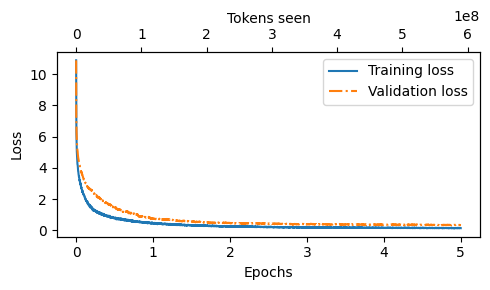

In [22]:
def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

# **Inference**

In [23]:
torch.manual_seed(100)

token_ids = generate(
    model=model,
    idx=text_to_token_ids("Drug A is", tokenizer).to(device),
    max_new_tokens=15,
    context_size=GPT_CONFIG_70M["context_length"],
    top_k=25,
    temperature=1.4
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Drug A is indicated for lornoxicam is indicated to treat severe postoperative pain,


# **Model Save**

In [24]:
torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    },
    "model_and_optimizer.pth"
)

# **Model Load**

In [25]:
checkpoint = torch.load("/acfs-home/azi4002/serag_AI_lab/users/azi4002/scripts/d3/d3/model_and_optimizer.pth", weights_only=True)

model = GPTModel(GPT_CONFIG_70M)
model.load_state_dict(checkpoint["model_state_dict"])

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.train();

# **Finetuning**

# **Imports**

In [26]:
import pandas as pd
from pathlib import Path
import math
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# **Dataset**

**Dataset Loading**

In [27]:
csv_file_path = Path(r"/acfs-home/azi4002/serag_AI_lab/users/azi4002/scripts/d3/datasets/d3_classification_data.csv")

df = pd.read_csv(csv_file_path, header=0)
df

print(df["Label"].value_counts())

Label
Moderate    23433
Minor       20975
Major       11417
Name: count, dtype: int64


**Dataset Mapping**

In [28]:
# Create a mapping dictionary for the unique labels
label_mapping = {label: idx for idx, label in enumerate(df["Label"].unique())}

# Map the labels to their corresponding integer values
df["Label"] = df["Label"].map(label_mapping)

print(label_mapping)  # To see the mapping of labels to numbers
print(df.head())  # To verify the changes in the DataFrame

{'Minor': 0, 'Moderate': 1, 'Major': 2}
   Label                                               Text
0      0  Rate the interaction severity between Abalopar...
1      0  How severe is the interaction between Abalopar...
2      0  Rate the interaction severity between Abalopar...
3      0  How severe is the interaction between Abalopar...
4      0  What is the risk level of combining Abaloparat...


**Dataset Splitting**

In [29]:
def stratified_split(df, train_frac, validation_frac):
    # First, split the data into train+validation and test sets
    train_val_df, test_df = train_test_split(
        df, test_size=1 - (train_frac + validation_frac), stratify=df["Label"], random_state=100
    )

    # Calculate the validation fraction relative to the train+validation set
    validation_relative_frac = validation_frac / (train_frac + validation_frac)

    # Now split the train+validation set into train and validation sets
    train_df, validation_df = train_test_split(
        train_val_df, test_size=validation_relative_frac, stratify=train_val_df["Label"], random_state=100
    )

    return train_df, validation_df, test_df

# Split the balanced dataset using stratified splitting
train_df, validation_df, test_df = stratified_split(df, 0.9, 0.05)

# Save the splits to CSV files
train_df.to_csv("train.csv", index=None)
validation_df.to_csv("validation.csv", index=None)
test_df.to_csv("test.csv", index=None)

# Verify the distribution of labels in each split
print("Train label distribution:")
print(train_df["Label"].value_counts())
print("\nValidation label distribution:")
print(validation_df["Label"].value_counts())
print("\nTest label distribution:")
print(test_df["Label"].value_counts())

Train label distribution:
Label
1    21089
0    18877
2    10275
Name: count, dtype: int64

Validation label distribution:
Label
1    1172
0    1049
2     571
Name: count, dtype: int64

Test label distribution:
Label
1    1172
0    1049
2     571
Name: count, dtype: int64


# **Data Loaders**

In [30]:
tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


In [31]:
class SpamDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_length=None, pad_token_id=50256):
        self.data = pd.read_csv(csv_file)

        # Pre-tokenize texts
        self.encoded_texts = [
            tokenizer.encode(text) for text in self.data["Text"]
        ]

        if max_length is None:
            self.max_length = self._longest_encoded_length()
        else:
            self.max_length = max_length
            # Truncate sequences if they are longer than max_length
            self.encoded_texts = [
                encoded_text[:self.max_length]
                for encoded_text in self.encoded_texts
            ]

        # Pad sequences to the longest sequence
        self.encoded_texts = [
            encoded_text + [pad_token_id] * (self.max_length - len(encoded_text))
            for encoded_text in self.encoded_texts
        ]

    def __getitem__(self, index):
        encoded = self.encoded_texts[index]
        label = self.data.iloc[index]["Label"]
        return (
            torch.tensor(encoded, dtype=torch.long),
            torch.tensor(label, dtype=torch.long)
        )

    def __len__(self):
        return len(self.data)

    def _longest_encoded_length(self):
        max_length = 0
        for encoded_text in self.encoded_texts:
            encoded_length = len(encoded_text)
            if encoded_length > max_length:
                max_length = encoded_length
        return max_length

In [32]:
train_dataset = SpamDataset(
    csv_file="train.csv",
    max_length=None,
    tokenizer=tokenizer
)

val_dataset = SpamDataset(
    csv_file="validation.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)

test_dataset = SpamDataset(
    csv_file="test.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)

In [33]:
num_workers = 0
batch_size = 8

torch.manual_seed(100)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

In [34]:
print("Train loader:")
for input_batch, target_batch in train_loader:
    pass

print("Input batch dimensions:", input_batch.shape)
print("Label batch dimensions", target_batch.shape)

print(f"{len(train_loader)} training batches")
print(f"{len(val_loader)} validation batches")
print(f"{len(test_loader)} test batches")

Train loader:
Input batch dimensions: torch.Size([8, 50])
Label batch dimensions torch.Size([8])
6280 training batches
349 validation batches
349 test batches


# **Classification**

In [35]:
print(model)

GPTModel(
  (tok_emb): Embedding(50257, 512)
  (pos_emb): Embedding(256, 512)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=512, out_features=512, bias=False)
        (W_key): Linear(in_features=512, out_features=512, bias=False)
        (W_value): Linear(in_features=512, out_features=512, bias=False)
        (out_proj): Linear(in_features=512, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=512, out_features=2048, bias=True)
          (1): GELU()
          (2): Linear(in_features=2048, out_features=512, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

In [36]:
for param in model.parameters():
    param.requires_grad = False

In [37]:
CHOOSE_MODEL = "gpt2-very-small (70M)"
INPUT_PROMPT = "Drug A is"

BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-very-small (70M)": {"emb_dim": 512, "n_layers": 8, "n_heads": 6},
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

In [38]:
torch.manual_seed(100)

num_classes = 3
model.out_head = torch.nn.Linear(in_features=BASE_CONFIG["emb_dim"], out_features=num_classes)

In [39]:
for param in model.trf_blocks[-1].parameters():
    param.requires_grad = True

for param in model.final_norm.parameters():
    param.requires_grad = True

In [40]:
inputs = tokenizer.encode("Drug A is")
inputs = torch.tensor(inputs,device=device).unsqueeze(0)
print("Inputs:", inputs)
print("Inputs dimensions:", inputs.shape) # shape: (batch_size, num_tokens)

Inputs: tensor([[37943,   317,   318]], device='cuda:0')
Inputs dimensions: torch.Size([1, 3])


In [41]:
# Define the device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Ensure the model is on the correct device
model = model.to(device)

In [42]:
with torch.no_grad():
    outputs = model(inputs)

print("Outputs:\n", outputs)
print("Outputs dimensions:", outputs.shape) # shape: (batch_size, num_tokens, num_classes)

Outputs:
 tensor([[[ 0.5264, -0.5678, -1.5600],
         [ 1.6738, -1.2925, -0.5242],
         [ 0.7729,  0.0898, -0.6487]]], device='cuda:0')
Outputs dimensions: torch.Size([1, 3, 3])


**Classification Accuracy and Loss**

In [43]:
probas = torch.softmax(outputs[:, -1, :], dim=-1)
label = torch.argmax(probas)
print("Class label:", label.item())

Class label: 0


In [44]:
logits = outputs[:, -1, :]
label = torch.argmax(logits)
print("Class label:", label.item())

Class label: 0


In [45]:
def calc_accuracy_loader(data_loader, model, device, num_batches=None):
    model.eval()
    correct_predictions, num_examples = 0, 0

    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            input_batch, target_batch = input_batch.to(device), target_batch.to(device)

            with torch.no_grad():
                logits = model(input_batch)[:, -1, :]  # Logits of last output token
            predicted_labels = torch.argmax(logits, dim=-1)

            num_examples += predicted_labels.shape[0]
            correct_predictions += (predicted_labels == target_batch).sum().item()
        else:
            break
    return correct_predictions / num_examples

In [46]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device) # no assignment model = model.to(device) necessary for nn.Module classes

torch.manual_seed(100) # For reproducibility due to the shuffling in the training data loader

train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=10)
val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=10)
test_accuracy = calc_accuracy_loader(test_loader, model, device, num_batches=10)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 17.50%
Validation accuracy: 20.00%
Test accuracy: 20.00%


In [47]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)[:, -1, :]  # Logits of last output token
    loss = torch.nn.functional.cross_entropy(logits, target_batch)
    return loss

In [48]:
# Same as in chapter 5
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [49]:
with torch.no_grad(): # Disable gradient tracking for efficiency because we are not training, yet
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)
    test_loss = calc_loss_loader(test_loader, model, device, num_batches=5)

print(f"Training loss: {train_loss:.3f}")
print(f"Validation loss: {val_loss:.3f}")
print(f"Test loss: {test_loss:.3f}")

Training loss: 2.356
Validation loss: 2.721
Test loss: 2.744


# **Training**

In [50]:
# # Updated train function with learning rate warmup, cosine decay, and gradient clipping
# def train_classifier(model, train_loader, val_loader, optimizer, device, num_epochs,
#                      eval_freq, eval_iter, warmup_steps, initial_lr=1e-5, min_lr=1e-8):

#     # Initialize lists to track losses, accuracies, learning rates, and examples seen
#     train_losses, val_losses, train_accs, val_accs, track_lrs = [], [], [], [], []
#     examples_seen, global_step = 0, -1

#     # Retrieve the maximum learning rate from the optimizer
#     peak_lr = optimizer.param_groups[0]["lr"]

#     # Calculate the total number of iterations in the training process
#     total_training_steps = len(train_loader) * num_epochs

#     # Calculate the learning rate increment during the warmup phase
#     lr_increment = (peak_lr - initial_lr) / warmup_steps

#     # Main training loop
#     for epoch in range(num_epochs):
#         model.train()  # Set model to training mode

#         for input_batch, target_batch in train_loader:
#             optimizer.zero_grad()  # Reset loss gradients from the previous batch iteration
#             global_step += 1

#             # Adjust the learning rate based on the current phase (warmup or cosine annealing)
#             if global_step < warmup_steps:
#                 # Linear warmup
#                 lr = initial_lr + global_step * lr_increment
#             else:
#                 # Cosine annealing after warmup
#                 progress = ((global_step - warmup_steps) /
#                             (total_training_steps - warmup_steps))
#                 lr = min_lr + (peak_lr - min_lr) * 0.5 * (1 + math.cos(math.pi * progress))

#             # Apply the calculated learning rate to the optimizer
#             for param_group in optimizer.param_groups:
#                 param_group["lr"] = lr
#             track_lrs.append(lr)  # Store the current learning rate

#             # Log learning rate to WandB
#             wandb.log({"learning_rate": lr})

#             # Calculate and backpropagate the loss
#             loss = calc_loss_batch(input_batch, target_batch, model, device)
#             loss.backward()  # Calculate loss gradients

#             # Apply gradient clipping to avoid exploding gradients after the warmup phase
#             if global_step >= warmup_steps:
#                 torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

#             optimizer.step()  # Update model weights using loss gradients
#             examples_seen += input_batch.shape[0]  # Track examples instead of tokens

#             # Optional evaluation step
#             if global_step % eval_freq == 0:
#                 train_loss, val_loss = evaluate_model(
#                     model, train_loader, val_loader, device, eval_iter)
#                 train_losses.append(train_loss)
#                 val_losses.append(val_loss)
#                 # Log train and validation losses to WandB
#                 wandb.log({"train_loss": train_loss, "val_loss": val_loss})
#                 print(f"Ep {epoch+1} (Step {global_step:06d}): "
#                       f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

#         # Calculate accuracy after each epoch
#         train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=eval_iter)
#         val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=eval_iter)
#         print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
#         print(f"Validation accuracy: {val_accuracy*100:.2f}%")
#         # Log accuracy values to WandB
#         wandb.log({"train_accuracy": train_accuracy, "val_accuracy": val_accuracy})
#         train_accs.append(train_accuracy)
#         val_accs.append(val_accuracy)

#     return train_losses, val_losses, train_accs, val_accs, examples_seen, track_lrs

In [51]:
# Updated train function with learning rate warmup, cosine decay, and gradient clipping
def train_classifier(model, train_loader, val_loader, optimizer, device, num_epochs,
                     eval_freq, eval_iter, warmup_steps, initial_lr=1e-5, min_lr=1e-8):
    
    # Initialize lists to track losses, accuracies, learning rates, and examples seen
    train_losses, val_losses, train_accs, val_accs, track_lrs = [], [], [], [], []
    examples_seen, global_step = 0, -1

    # Retrieve the maximum learning rate from the optimizer
    peak_lr = optimizer.param_groups[0]["lr"]

    # Calculate the total number of iterations in the training process
    total_training_steps = len(train_loader) * num_epochs

    # Calculate the learning rate increment during the warmup phase
    lr_increment = (peak_lr - initial_lr) / warmup_steps

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()  # Reset loss gradients from the previous batch iteration
            global_step += 1

            # Adjust the learning rate based on the current phase (warmup or cosine annealing)
            if global_step < warmup_steps:
                # Linear warmup
                lr = initial_lr + global_step * lr_increment
            else:
                # Cosine annealing after warmup
                progress = ((global_step - warmup_steps) /
                            (total_training_steps - warmup_steps))
                lr = min_lr + (peak_lr - min_lr) * 0.5 * (1 + math.cos(math.pi * progress))

            # Apply the calculated learning rate to the optimizer
            for param_group in optimizer.param_groups:
                param_group["lr"] = lr
            track_lrs.append(lr)  # Store the current learning rate

            # Log learning rate to WandB
            wandb.log({"learning_rate": lr})

            # Calculate and backpropagate the loss
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()  # Calculate loss gradients

            # Apply gradient clipping to avoid exploding gradients after the warmup phase
            if global_step >= warmup_steps:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()  # Update model weights using loss gradients
            examples_seen += input_batch.shape[0]  # Track examples instead of tokens

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                # Log train and validation losses to WandB
                wandb.log({"train_loss": train_loss, "val_loss": val_loss})
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Calculate accuracy after each epoch
        train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=eval_iter)
        val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=eval_iter)
        print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")  
        print(f"Validation accuracy: {val_accuracy*100:.2f}%")
        # Log accuracy values to WandB
        wandb.log({"train_accuracy": train_accuracy, "val_accuracy": val_accuracy})
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)

    return train_losses, val_losses, train_accs, val_accs, examples_seen, track_lrs

In [52]:
# # Same as chapter 5
# def evaluate_model(model, train_loader, val_loader, device, eval_iter):
#     model.eval()
#     with torch.no_grad():
#         train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
#         val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
#     model.train()

#     # Log train and validation losses to WandB
#     wandb.log({
#         "train_loss": train_loss,
#         "val_loss": val_loss
#     })

#     return train_loss, val_loss

In [53]:
# Same as chapter 5: Evaluation function
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()

    # Log train and validation losses to WandB
    wandb.log({
        "train_loss": train_loss,
        "val_loss": val_loss
    })

    return train_loss, val_loss


In [54]:
# # Initialize the start time to calculate the execution duration
# start_time = time.time()

# # Set the seed for reproducibility
# torch.manual_seed(100)

# # Set learning rate values and create the optimizer
# initial_lr = 1e-5    # Initial learning rate for warmup
# peak_lr = 1e-4       # Peak learning rate during the main training phase
# min_lr = 1e-8        # Minimum learning rate for cosine decay

# # Create the optimizer
# optimizer = torch.optim.AdamW(model.parameters(), lr=peak_lr, weight_decay=0.1)

# # Hyperparameters
# num_epochs = 10
# warmup_steps = 8000
# eval_freq = 100
# eval_iter = 100

# # Initialize WandB to track the experiment
# wandb.init(project="D3_Pretraining_Finetuning", name="D3_Finetuning_Run")

# # Log hyperparameters to WandB
# wandb.config.update({
#     "learning_rate": initial_lr,
#     "peak_lr": peak_lr,
#     "min_lr": min_lr,
#     "num_epochs": num_epochs,
#     "warmup_steps": warmup_steps,
#     "batch_size": train_loader.batch_size,
#     "optimizer": "AdamW"
# })

# # Train the model using the updated train_classifier function with learning rate adjustments and gradient clipping
# train_losses, val_losses, train_accs, val_accs, examples_seen, track_lrs = train_classifier(
#     model, train_loader, val_loader, optimizer, device,
#     num_epochs=num_epochs, eval_freq=eval_freq, eval_iter=eval_iter,
#     warmup_steps=warmup_steps, initial_lr=initial_lr, min_lr=min_lr
# )

# # Calculate and log the execution time in minutes to WandB
# end_time = time.time()
# execution_time_minutes = (end_time - start_time) / 60
# wandb.log({"execution_time_minutes": execution_time_minutes})

# # Print the execution time
# print(f"Training completed in {execution_time_minutes:.2f} minutes.")

# # Finish the WandB run
# wandb.finish()

In [55]:
# Initialize the start time to calculate the execution duration
start_time = time.time()

# Set the seed for reproducibility
torch.manual_seed(100)

# Set learning rate values and create the optimizer
initial_lr = 1e-5    # Initial learning rate for warmup
peak_lr = 1e-4       # Peak learning rate during the main training phase
min_lr = 1e-8        # Minimum learning rate for cosine decay

# Create the optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=peak_lr, weight_decay=0.1)

# Hyperparameters
num_epochs = 10
warmup_steps = 8000
eval_freq = 100
eval_iter = 100

# Initialize WandB to track the experiment
wandb.init(project="D3_Pretraining_Finetuning", name="D3_Finetuning_Run")

# Log hyperparameters to WandB
wandb.config.update({
    "learning_rate": initial_lr,
    "peak_lr": peak_lr,
    "min_lr": min_lr,
    "num_epochs": num_epochs,
    "warmup_steps": warmup_steps,
    "batch_size": train_loader.batch_size,
    "optimizer": "AdamW"
})

# Train the model using the updated train_classifier function with learning rate adjustments and gradient clipping
train_losses, val_losses, train_accs, val_accs, examples_seen, track_lrs = train_classifier(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=eval_freq, eval_iter=eval_iter,
    warmup_steps=warmup_steps, initial_lr=initial_lr, min_lr=min_lr
)

# Calculate and log the execution time in minutes to WandB
end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
wandb.log({"execution_time_minutes": execution_time_minutes})

# Print the execution time
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

# Finish the WandB run
wandb.finish()

Ep 1 (Step 000000): Train loss 2.285, Val loss 2.376
Ep 1 (Step 000100): Train loss 1.039, Val loss 1.044
Ep 1 (Step 000200): Train loss 1.134, Val loss 1.100
Ep 1 (Step 000300): Train loss 1.042, Val loss 0.997
Ep 1 (Step 000400): Train loss 0.944, Val loss 0.935
Ep 1 (Step 000500): Train loss 0.977, Val loss 0.953
Ep 1 (Step 000600): Train loss 0.888, Val loss 0.892
Ep 1 (Step 000700): Train loss 0.870, Val loss 0.869
Ep 1 (Step 000800): Train loss 0.935, Val loss 0.994
Ep 1 (Step 000900): Train loss 0.800, Val loss 0.842
Ep 1 (Step 001000): Train loss 0.789, Val loss 0.811
Ep 1 (Step 001100): Train loss 0.817, Val loss 0.817
Ep 1 (Step 001200): Train loss 0.845, Val loss 0.833
Ep 1 (Step 001300): Train loss 0.805, Val loss 0.788
Ep 1 (Step 001400): Train loss 0.827, Val loss 0.875
Ep 1 (Step 001500): Train loss 0.730, Val loss 0.736
Ep 1 (Step 001600): Train loss 0.837, Val loss 0.834
Ep 1 (Step 001700): Train loss 0.709, Val loss 0.741
Ep 1 (Step 001800): Train loss 0.723, Val loss

execution_time_minutes,▁
learning_rate,▂▂▂▃▄▆▆▇████▇▇▇▇▇▆▆▆▅▅▅▅▅▄▄▃▃▃▃▂▂▂▂▁▁▁▁▁
train_accuracy,▁▄▅▆▆▆█▇▆▇
train_loss,██▆▅▃▆▄▃▄▄▄▄▄▃▅▃▃▃▃▃▃▃▃▃▃▂▂▂▂▁▁▂▁▂▂▃▂▁▂▁
val_accuracy,▁▄▄▅▇█████
val_loss,███▅▅▅▄▃▃▃▃▃▂▂▂▂▂▃▂▂▂▂▂▃▂▂▁▂▁▂▁▁▂▁▁▁▁▁▁▁
execution_time_minutes,35.64732
learning_rate,0.0
train_accuracy,0.9
train_loss,0.30909
val_accuracy,0.86875


**Plots**

In [56]:
def plot_values(epochs_seen, examples_seen, train_values, val_values, label="loss"):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(epochs_seen, val_values, linestyle="-.", label=f"Validation {label}")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

    # Create a second x-axis for examples seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(examples_seen, train_values, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Examples seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig(f"{label}-plot.pdf")
    plt.show()

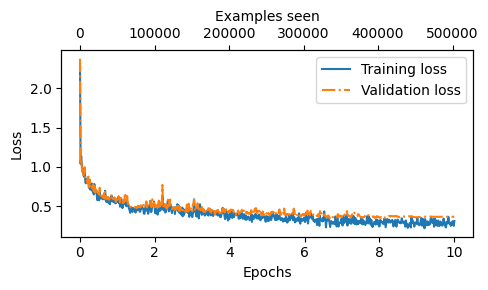

In [57]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))

plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

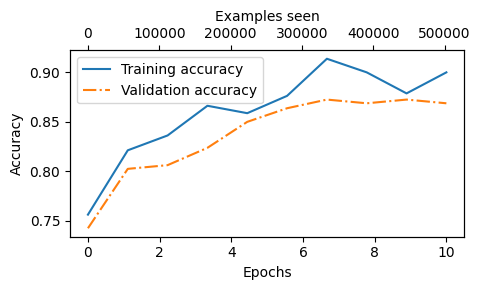

In [58]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))

plot_values(epochs_tensor, examples_seen_tensor, train_accs, val_accs, label="accuracy")

**Metrics**

In [59]:
train_accuracy = calc_accuracy_loader(train_loader, model, device)
val_accuracy = calc_accuracy_loader(val_loader, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 89.91%
Validation accuracy: 86.75%
Test accuracy: 87.11%


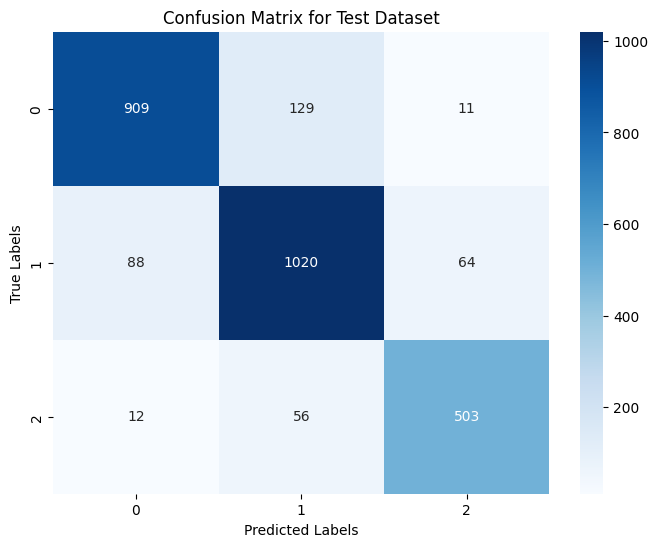

In [60]:
# Function to calculate predictions and true labels for a given data loader
def get_predictions_and_labels(data_loader, model, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for input_batch, target_batch in data_loader:
            input_batch, target_batch = input_batch.to(device), target_batch.to(device)
            logits = model(input_batch)[:, -1, :]  # Logits of last output token
            predicted_labels = torch.argmax(logits, dim=-1)
            all_preds.extend(predicted_labels.cpu().numpy())
            all_labels.extend(target_batch.cpu().numpy())
    return np.array(all_preds), np.array(all_labels)

# Get predictions and true labels for the test dataset
test_preds, test_labels = get_predictions_and_labels(test_loader, model, device)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(test_labels, test_preds)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="g")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix for Test Dataset")
plt.show()

# **Inference**

In [61]:
# def classify_review(text, model, tokenizer, device, max_length=None, pad_token_id=50256):
#     model.eval()

#     # Prepare inputs to the model
#     input_ids = tokenizer.encode(text)
#     supported_context_length = model.pos_emb.weight.shape[0]

#     # Truncate sequences if they are too long
#     if max_length:
#         input_ids = input_ids[:min(max_length, supported_context_length)]
#     else:
#         input_ids = input_ids[:supported_context_length]

#     # Pad sequences to the required length if max_length is specified
#     if max_length:
#         input_ids += [pad_token_id] * (max_length - len(input_ids))
#     input_tensor = torch.tensor(input_ids, device=device).unsqueeze(0)  # add batch dimension

#     # Model inference
#     with torch.no_grad():
#         logits = model(input_tensor)[:, -1, :]  # Logits of the last output token
#     predicted_label_index = torch.argmax(logits, dim=-1).item()

#     # Map the predicted index back to the actual label
#     label_mapping = {0: "Minor", 1: "Moderate", 2: "Major"}  # Example of label mappings
#     predicted_label = label_mapping.get(predicted_label_index, "Unknown")

#     # Return the classified result
#     return predicted_label

In [62]:
# text_1 = (
#     "What is the severity of the interaction when Risankizumab and Fluticasone are co-administered? Major or Moderate or Minor"
# )

# print(classify_review(
#     text_1, model, tokenizer, device, max_length=train_dataset.max_length
# ))